In [ ]:
#| hide
import logging

# Turn off logging for datasets
logging.getLogger("datasets").setLevel(logging.ERROR)

# Tutorial - Exploratory Data Analysis

> This notebook is a tutorial on how to use the `perplexed` library to perform exploratory data analysis (EDA) on a dataset. It is intended to be a quick introduction to the library, and is not intended to be a comprehensive guide to the library.

Let's get some data to work with. We'll use the `wikitext` dataset from the `datasets` library.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("wikitext", "wikitext-103-raw-v1", split="test").select(range(1_000))
dataset = dataset.filter(lambda x: len(x["text"]) > 0)

/home/nathan/miniconda3/envs/perplexed/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset wikitext (/home/nathan/.cache/huggingface/datasets/wikitext/wikitext-103-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)
Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/wikitext/wikitext-103-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126/cache-ceb6bd7c8619d4cb.arrow


Now let's find a model to use. We'll use the `EleutherAI/gpt-neo-125M` model from the `transformers` library.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-125M")

Now that all of that is done, we can start using `perplexed` to perform EDA on the dataset. Let's run our model on the dataset and get the perplexity of each sample.

In [ ]:
from perplexed.core import perplexed

perplexity_cnt, token_cnt = perplexed(
    model,
    dataset,
    tokenizer=tokenizer,
    column="text",
    batch_size=1,
    device="cpu",
    return_tokens=True
)

Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/wikitext/wikitext-103-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126/cache-35d4a307752a997a.arrow


The `perplexed` function returns two values: a Counter object containing the perplexity of each token, and the total number of tokens in the dataset. We can now explore things like what the most perplexed tokens are:

In [ ]:
perplexity_cnt.most_common(10)

[(' unavoid', 6007780352.0),
 (' Explosive', 188573856.0),
 (' wired', 60983452.0),
 (' 768', 21569920.0),
 (' ridden', 15362581.0),
 (' Influ', 15165454.0),
 (' esche', 14969172.0),
 (' reluctant', 14123441.0),
 (' succumb', 12422194.0),
 (' Arm', 12384815.0)]

You can also look at what the perplexity is for the most common tokens:

In [ ]:
tokens, _ = zip(*token_cnt.most_common(10))
# show the perplexity for the most common tokens
for token in tokens:
    print(token, perplexity_cnt[token])

 the 3.5897090435028076
, 21.938007354736328
. 10.295743942260742
 of 2.934633731842041
 and 9.320274353027344
 in 10.81938648223877
 to 4.0181355476379395
 a 10.546797752380371
 @ 10436.27734375
@ 29.87317657470703


Or you can do the least common tokens:

In [ ]:
tokens, _ = zip(*token_cnt.most_common()[-10:])
# show the perplexity for the least common tokens
for token in tokens:
    print(token, perplexity_cnt[token])

 designation 18.893896102905273
 99 4433.51416015625
 Much 3717.565185546875
 urban 15859.9248046875
 residential 4258.7236328125
 businesses 3.116973638534546
 rural 691.44921875
 Rural 65607.2265625
 Cemetery 24.99341583251953
 terminating 93.44629669189453


Now if you want to look at the distribution of perplexities, you can do that too!

In [ ]:
perplexity_dist, token_cnt = perplexed(
    model,
    dataset,
    tokenizer=tokenizer,
    column="text",
    batch_size=1,
    device="cpu",
    return_tokens=True,
    return_distributions=True,
)

Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/wikitext/wikitext-103-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126/cache-35d4a307752a997a.arrow


Now instead of a Counter object, `perplexed` returns a dictionary mapping each token to the different perplexities it has. So, if we are so inclined, we could make a boxplot of the perplexities for each token:

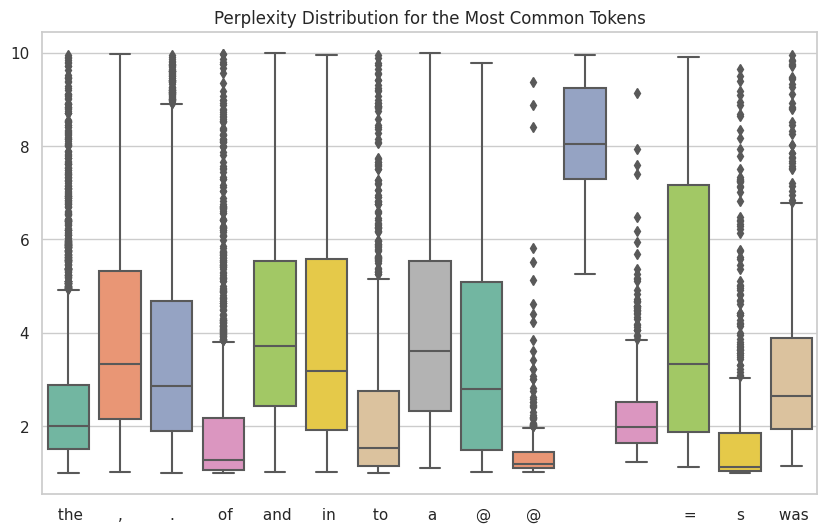

In [ ]:
# boxplot the distribution of perplexities for the most common tokens
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")

most_common = token_cnt.most_common(15)
most_common_tokens = [token for token, _ in most_common]
most_common_perplexities = [list(filter(lambda x: x < 10, perplexity_dist[token])) for token in most_common_tokens]

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(data=most_common_perplexities, palette="Set2")
ax.set_xticklabels(most_common_tokens)
ax.set_title("Perplexity Distribution for the Most Common Tokens")
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()